In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/Schlumberger/joint-vae.git

Cloning into 'joint-vae'...
remote: Enumerating objects: 94, done.
remote: Total 94 (delta 0), reused 0 (delta 0), pack-reused 94
Unpacking objects: 100% (94/94), done.


In [ ]:
import pathlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import tensorflow as tf

In [ ]:
import PIL
import os
import os.path
from PIL import Image

f = r'/content/drive/MyDrive/maps_data'
for file in os.listdir(f):
    f_img = f+"/"+file
    #print(f_img)
    if ".ipynb" in f_img:
      continue
    img = Image.open(f_img)
    img = img.resize((289,289))
    img.save(f_img)

In [ ]:
import os

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
print(PROJECT_PATH)
DATAPATH = os.path.join(PROJECT_PATH,'content/drive/MyDrive','maps_data')
print(DATAPATH)

/
/content/drive/MyDrive/maps_data


In [ ]:
data_root = pathlib.Path(DATAPATH)
print(data_root)

/content/drive/MyDrive/maps_data


In [ ]:
import sys
import os
import tensorflow as tf
import random


def preprocess_image(image):
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, [289, 289])
    image /= 255.0  # normalize to [0,1] range

    return image


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


def get_filepaths(dirpath):
    """
    Return paths of all files in a directory.
    :param dirpath:
    :return:
    """
    data_root = pathlib.Path(dirpath)
    all_image_paths = list(data_root.glob('*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)

    return all_image_paths


def load_dataset(dirpath):

    all_image_paths = get_filepaths(dirpath)
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return image_ds

In [ ]:
ds = load_dataset(data_root)

In [ ]:
from torch.utils import data
import sys

#sys.path.append('../')
from torchvision import datasets
# from skimage import io, transform
import os

from PIL import Image

import torch
from PIL import Image, ImageOps
import numpy as np

import torchvision
import torchvision.transforms.functional as trF


class Invert(object):
    """Inverts the color channels of an PIL Image
    while leaving intact the alpha channel.
    """

    def invert(self, img):
        r"""Invert the input PIL Image.
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        #if not trF._is_pil_image(img):
        #    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            inv = Image.merge('RGB', (r, g, b))
            #inv = ImageOps.invert(rgb)
            #r, g, b = inv.split()
            #inv = Image.merge('RGBA', (r, g, b, a))
        elif img.mode == 'LA':
            l, a = img.split()
            l = ImageOps.invert(l)
            inv = Image.merge('LA', (l, a))
        else:
            inv = ImageOps.invert(img)
        return inv

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        return self.invert(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

class CityImageDataset(data.Dataset):
    """
    Urban images dataset.
    """

    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = [f for f in os.listdir(root) if not f.startswith('.')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root,self.image_files[idx])
        sample = Image.open(img_name)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
city_dataset = CityImageDataset(root=data_root,transform=torchvision.transforms.Compose([    
    #torchvision.transforms.Grayscale(num_output_channels=3),                                                                                 
    Invert(),
    torchvision.transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

In [ ]:
city_dataset.__len__()

5320

In [ ]:
validation_split = .2
shuffle_dataset = True
random_seed= 42
dataset_size = len(city_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

In [ ]:
batch_size = 64
lr = 0.001
epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(city_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(city_dataset, batch_size=batch_size,
                                                sampler=test_sampler)

In [ ]:
len(train_sampler)

4256

In [ ]:
latent_spec = {'cont': 10,
               'disc': [10]}

In [ ]:
%pwd

'/content/joint-vae/viz'

In [ ]:
%cd ../jointvae

/content/joint-vae/jointvae


In [ ]:
%cd joint-vae/jointvae/
!python models.py
from models import VAE

model = VAE(latent_spec=latent_spec, img_size=(3, 289, 289), use_cuda=True)

In [ ]:
print(model)

VAE(
  (img_to_features): Sequential(
    (0): Conv2d(3, 143, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(143, 143, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(143, 289, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(289, 289, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (features_to_hidden): Sequential(
    (0): Linear(in_features=83521, out_features=289, bias=True)
    (1): ReLU()
  )
  (fc_mean): Linear(in_features=289, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=289, out_features=10, bias=True)
  (fc_alphas): ModuleList(
    (0): Linear(in_features=289, out_features=10, bias=True)
  )
  (latent_to_features): Sequential(
    (0): Linear(in_features=20, out_features=289, bias=True)
    (1): ReLU()
    (2): Linear(in_features=289, out_features=83521, bias=True)
    (3): ReLU()
  )
  (features_to_img): Sequential(
    (0): ConvTranspose2d(289,

In [ ]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
%cd ../jointvae/
!python training.py
from training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,use_cuda=True)

/content/joint-vae/jointvae


In [ ]:
%pwd

'/content/joint-vae/jointvae'

In [ ]:
%cd ../viz/
!python visualize.py
# Build a visualizer which will be passed to trainer to visualize progress during training
from visualize import Visualizer

viz = Visualizer(model)

/content/joint-vae/viz


In [ ]:
for batch_idx, data in enumerate(train_loader):
  print(data.shape)

torch.Size([64, 3, 286, 286])
torch.Size([64, 3, 286, 286])
torch.Size([64, 3, 286, 286])
torch.Size([64, 3, 286, 286])


KeyboardInterrupt: ignored

In [ ]:
%pwd

'/content/joint-vae/viz'

In [ ]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

trainer.train(train_loader, epochs=50, save_training_gif=('./training.gif', viz))

0/5320	Loss: 58221.178
3200/5320	Loss: 37779.242
Epoch: 1 Average loss: 29592.35
0/5320	Loss: 31994.327
3200/5320	Loss: 31059.212
Epoch: 2 Average loss: 24953.24
0/5320	Loss: 28486.189
3200/5320	Loss: 29787.973
Epoch: 3 Average loss: 23936.89
0/5320	Loss: 29146.159
3200/5320	Loss: 29272.813
Epoch: 4 Average loss: 23378.36
0/5320	Loss: 32562.349
3200/5320	Loss: 28426.435
Epoch: 5 Average loss: 22800.89
0/5320	Loss: 28097.821
3200/5320	Loss: 27657.154
Epoch: 6 Average loss: 22427.18
0/5320	Loss: 25353.893
3200/5320	Loss: 27610.144
Epoch: 7 Average loss: 22235.49
0/5320	Loss: 27611.363
3200/5320	Loss: 27301.223
Epoch: 8 Average loss: 21967.97
0/5320	Loss: 27079.624
3200/5320	Loss: 27446.626
Epoch: 9 Average loss: 21805.80
0/5320	Loss: 32355.595
3200/5320	Loss: 26584.599
Epoch: 10 Average loss: 21577.23
0/5320	Loss: 24103.954
3200/5320	Loss: 26389.428
Epoch: 11 Average loss: 21411.02
0/5320	Loss: 27799.196
3200/5320	Loss: 26063.802
Epoch: 12 Average loss: 21210.06
0/5320	Loss: 25873.233
32

In [ ]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt

# Get a batch of data
for batch_idx, batch in enumerate(test_loader):
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.imshow(recon.numpy()[0, :, :])

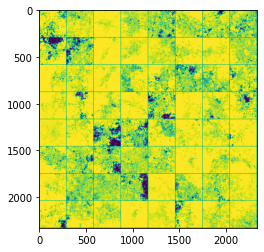

In [ ]:
# Plot samples
samples = viz.samples()
plt.imshow(samples.numpy()[0, :, :])

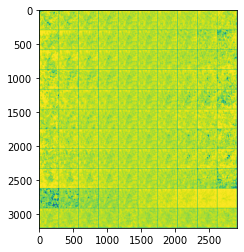

In [ ]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=10)
plt.imshow(traversals.numpy()[0, :, :])

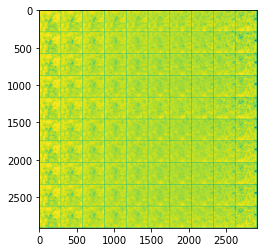

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))
plt.imshow(traversals.numpy()[0, :, :])

In [ ]:
import numpy as np
import torch


def metric_model(model, data_loader, batch_size=800, M=500, L=100,
                 thresh=1.0, num_factors=5, use_cuda=False):
    """Computes disentanglement metric on model using data in data_loader."""
    # Sample a batch of data from dataset
    indices = np.random.randint(0, len(data_loader.dataset), size=batch_size)
    batch = torch.stack([data_loader.dataset[i] for i in indices])
    # Get the latent factors which generated the data
    factors = np.zeros((batch_size, num_factors))
    for i in range(batch_size):
        factors[i] = latents_from_idx(indices[i])
    factors = torch.Tensor(factors)
    if use_cuda:
        batch = batch.cuda()
        factors = factors.cuda()

    # Encode data to get latents
    latent_dist = model.encode(batch)

    # Remove "inactive dimensions" (see Kim et. al paper appendix). These
    # inactive dimensions are defined as ones where the KL between the
    # posterior and the prior are below a certain threshold

    # Calculate KL divergence for continuous variables
    mean, logvar = latent_dist['cont']
    kl_values = -0.5 * (1 + logvar - mean.pow(2) - logvar.exp())
    kl_means = torch.mean(kl_values, dim=0)
    # Remove latents with low KL
    mask = kl_means > thresh
    print("Keep {} dimensions.".format(mask.sum().item()))
    latents_cont = latent_dist['cont'][0].detach().clone()[:, mask]
    _, latents_disc = latent_dist['disc'][0].max(dim=1)

    # Calculate KL divergence for discrete variables
    alpha = latent_dist['disc'][0]
    disc_dim = int(alpha.size()[-1])
    log_dim = torch.Tensor([np.log(disc_dim)])
    if use_cuda:
        log_dim = log_dim.cuda()
    # Calculate negative entropy of each row
    neg_entropy = torch.sum(alpha * torch.log(alpha + 1e-12), dim=1)
    # Take mean of negative entropy across batch
    mean_neg_entropy = torch.mean(neg_entropy, dim=0)
    # KL loss of alpha with uniform categorical variable
    kl_disc = log_dim + mean_neg_entropy
    if kl_disc.item() < thresh:
        print("Removing discrete dimension.")
        latents = latents_cont.clone()
    else:
        latents = torch.cat([latents_cont, latents_disc.float().unsqueeze(1)], dim=1)
    if use_cuda:
        latents = latents.cuda()

    # Calculate empirical standard deviations
    latents_cont_std = torch.std(latents_cont, dim=0)
    latents_disc_std = torch.sqrt(discrete_variance(latents_disc))
    if use_cuda:
        latents_disc_std = latents_disc_std.cuda()
    if kl_disc.item() < thresh:
        latents_std = latents_cont_std.clone()
    else:
        latents_std = torch.cat([latents_cont_std, latents_disc_std.float()], dim=0)

    # Initialize variances
    _, num_latents = latents.size()
    variances = torch.zeros(num_latents, num_factors, device=latents_std.device)
    if use_cuda:
        variances = variances.cuda()
    # Find unique factors and prefix a sample of them
    factors_unique = [factor.unique() for factor in factors.cpu().split(1, dim=1)]
    fixed_factor_indices = np.random.randint(0, num_factors, size=M)
    if use_cuda:
        factors = factors.cuda()
        factors_unique = [factor.cuda() for factor in factors_unique]
    # Iterate and calculate metric
    for m in range(M):
        fixed_factor_idx = fixed_factor_indices[m]
        fixed_factor_vals = factors_unique[fixed_factor_idx]
        fixed_factor_val = fixed_factor_vals[np.random.choice(len(fixed_factor_vals))]
        # Choose random latents
        factor_bool = factors[:, fixed_factor_idx] == fixed_factor_val
        if use_cuda:
            factor_bool = factor_bool.cuda()
        latents_subset = latents[factor_bool]
        # Randomly choose L points as in paper
        latents_subset = latents_subset[torch.randperm(latents_subset.size(0))][:L]
        # Calculate variance of continous dimensions, i.e. the first
        # num_latents - 1 indices of the latents
        var_cont = torch.var(latents_subset[:, :-1], dim=0)
        # Calculate variance of discrete dimensions, i.e. the last latent in
        # the latents tensor
        var_disc = discrete_variance(latents_subset[:, -1])
        if use_cuda:
            var_disc = var_disc.cuda()
        var_all = torch.cat([var_cont, var_disc], dim=0)
        # Total distance (as defined in paper)
        dist = var_all / latents_std
        d_star = torch.argmin(dist, dim=0)
        # Increment "vote"
        variances[d_star, fixed_factor_idx] += 1
    return torch.max(variances, dim=1)[0].sum().item() / M


def latents_from_idx(idx):
    """Returns the latent variables which generated the data at idx (following)
    index order given in initial dataset."""
    # Shapes, scale, orientation, posX, posY
    n_shape = 3
    n_scale = 6
    n_orientation = 40
    n_posx = 32
    n_posy = 32

    latent_posy = idx % n_posy
    latent_posx = int(idx / n_posy) % n_posx
    latent_orientation = int(idx / (n_posy * n_posx)) % n_orientation
    latent_scale = int(idx / (n_posy * n_posx * n_orientation)) % n_scale
    latent_shape = int(idx / (n_posy * n_posx * n_orientation * n_scale)) % n_scale

    return (latent_shape, latent_scale, latent_orientation, latent_posx, latent_posy)


def discrete_variance(disc_latents):
    """Gini's definition empirical variance."""
    n = disc_latents.size(0)
    dist = 0.
    for i in range(n):
        for j in range(n):
            if disc_latents[i] != disc_latents[j]:
                dist += 1.
    return torch.Tensor([dist / (2 * n * (n - 1))])

In [ ]:
metric_model(model, train_loader)

NameError: ignored